In [120]:
import csv
import numpy as np
import datetime
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.sparse import csc_matrix
from dateutil import rrule
from collections import OrderedDict
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
############################################################################
## Data Cleaning Methods
############################################################################

# Generate ruleset for holiday observances on the NYSE
def NYSE_holidays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()

    # Include all potential holiday observances
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=31, byweekday=rrule.FR)) # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 1))                     # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 2, byweekday=rrule.MO)) # New Years Day    
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, byweekday= rrule.MO(3)))            # Martin Luther King Day   
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 2, byweekday= rrule.MO(3)))            # Washington's Birthday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, byeaster= -2))                                  # Good Friday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 5, byweekday= rrule.MO(-1)))           # Memorial Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 3, byweekday=rrule.FR)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 4))                     # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 5, byweekday=rrule.MO)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 9, byweekday= rrule.MO(1)))            # Labor Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=11, byweekday= rrule.TH(4)))            # Thanksgiving Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=24, byweekday=rrule.FR)) # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=25))                     # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=26, byweekday=rrule.MO)) # Christmas 
    
    # Exclude potential holidays that fall on weekends
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, until=b, byweekday=(rrule.SA,rrule.SU)))

    return rs
    
# Generate ruleset for NYSE trading days

def NYSE_tradingdays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()
    rs.rrule(rrule.rrule(rrule.DAILY, dtstart=a, until=b))
    
    # Exclude weekends and holidays
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, byweekday=(rrule.SA,rrule.SU)))
    rs.exrule(NYSE_holidays(a,b))
    
    return rs

def is_wed(dt):
    return np.is_busday(dt, weekmask='0010000')

In [87]:
################################################################################# 
## Method for option price and volatility calculations
#################################################################################
''' 
with the 2 factor stochastic volatility jump model the solution has the form 
 exp(alpha + beta_0 * X + beta_1 * V1 + beta_2 * V2), where beta_0 = u, and beta_1, beta_2 is the same for all
 compensators for the SVJ models v(dt, dx, dy)
 alpha = alpha0 + terms depending on compensator
'''

def beta(tau, u, kappa, sigma, rho):
    a = -u**2
    b = sigma * rho * u - kappa
    gamma = np.sqrt(b**2 + a * sigma**2)
    return -a * (1 - np.exp(-gamma * tau)) / (2 * gamma - (gamma + b) * (1 - np.exp(-gamma * tau)))

def alpha0(tau, u, kappa1, sigma1, rho1, vbar1, kappa2, sigma2, rho2, vbar2, r, div_rate):
    a = -u**2
    b1 = sigma1 * rho1 * u - kappa1
    gamma1 = np.sqrt(b1**2 + a * sigma1**2)
    b2 = sigma2 * rho2 * u - kappa2
    gamma2 = np.sqrt(b2**2 + a * sigma2**2)
    
    return -r * tau + (r - div_rate) * u * tau \
        - kappa1 * vbar1 * ((gamma1 + b1) / (sigma1**2) * tau + \
                2 / (sigma1**2) * np.log(1 - (gamma1 + b1) * (1 - np.exp(- gamma1 * tau)) / (2 * gamma1))) \
        - kappa2 * vbar2 * ((gamma2 + b2) / (sigma2**2) * tau + \
                2 / (sigma2**2) * np.log(1 - (gamma2 + b2) * (1 - np.exp(- gamma2 * tau)) / (2 * gamma2)))    

# the SVJJ model by Duffie et. al. (2000)
def int_theta_SVJJ(tau, u, mu_x, sigma_x, mu_y, rho_j, kappa, sigma, rho):
    a = -u**2
    b = sigma * rho * u - kappa
    gamma = np.sqrt(b**2 + a * sigma**2)
    c = 1 - rho_j * mu_y * u
    d = (gamma - b) / ((gamma - b) * c + mu_y * a) * tau \
        - 2 * mu_y * a / ((gamma * c)**2 - (b * c - mu_y * a)**2) * \
            np.log(1 - ((gamma + b) * c - mu_y * a) / (2 * gamma * c) * (1 - np.exp(-gamma * tau)))
    
    return np.exp(mu_x * u + 0.5 * sigma_x**2 * u**2) * d

# the transform of state (X, V1, V2) with SVJJ model
def phi_SVJJ(u, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
             eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    tau = T - t
    lam = eta0 + eta1 * V1 + eta2 * V2
    a0 = alpha0(tau, u, kappa1, sigma1, rho1, vbar1, kappa2, sigma2, rho2, vbar2, r, div_rate)
    int_theta = int_theta_SVJJ(tau, u, mu_x, sigma_x, mu_y, rho_j, kappa1, sigma1, rho1)
    a = a0 - lam * tau + lam * int_theta
    b0 = u
    b1 = beta(tau, u, kappa1, sigma1, rho1)
    b2 = beta(tau, u, kappa2, sigma2, rho2)
    
    return np.exp(a + b0 * X + b1 * V1 + b2 * V2)

##########################################################################################
## Calculate the price using the inverse transform 
##########################################################################################

def calc_G_SVJJ(a, b, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    # y can be an array of log strike prices
    t = 0
    upperbound = 500
    sep = 1
    sep2 = 10
    sep3 = 100
    step_size1 = 0.001
    step_size2 = 0.01
    step_size3 = 0.05
    step_size4 = 0.5

    step_sizes = np.concatenate((step_size1 * np.ones(int(sep / step_size1)), \
                                 step_size2 * np.ones(int((sep2 - sep) / step_size2)), \
                                 step_size3 * np.ones(int((sep3 - sep2) / step_size3)),
                                step_size4 * np.ones(int((upperbound - sep3) / step_size4))))
    v_arr1 = np.arange(start=0, stop=sep, step=step_size1)
    v_arr2 = np.arange(start=sep, stop=sep2, step=step_size2)
    v_arr3 = np.arange(start=sep2, stop=sep3, step=step_size3)
    v_arr4 = np.arange(start=sep3, stop=upperbound+step_size4, step=step_size4)
    v_arr = np.concatenate((v_arr1, v_arr2, v_arr3, v_arr4))
    u_arr = a + b * v_arr * 1j
    phi_arr = phi_SVJJ(u_arr, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    inv_arr = np.exp(-np.outer(y, v_arr) * 1j)
    temp = np.imag(phi_arr * inv_arr) / (v_arr + 1e-15)
    #trapezoidal rule
    integr = np.sum((temp[:,0:-1] + temp[:,1:]) / 2 * (step_sizes), axis=1) / np.pi
    return phi_SVJJ(a, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j) / 2 - integr

def price_SVJJ(y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    G0 = calc_G_SVJJ(1e-7, 1, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    G1 = calc_G_SVJJ(1, 1, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    return np.exp(y) * G0 - G1


#Black Scholes volatility
def BSIV(X, y, r, T, price):
    # Find BSIV using Newton's method
    sigma = 0.3
    sigma_old = sigma
    for i in range(10):
        d1 = (X - y + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        BS_price = norm.cdf(-d2) * np.exp(y - r * T) - norm.cdf(-d1) * np.exp(X)
        vega = np.exp(y - r * T) * norm.pdf(d2) * np.sqrt(T)
        sigma = sigma_old - (BS_price - price) / vega
        if (abs(sigma - sigma_old) < 1e-6):
            break
        if (sigma > 2 | pd.isnull(sigma)): #bound the volatility to prevent code from breaking in edge cases
            sigma = 2
        if (sigma <= 0):
            sigma = 0.01
        sigma_old = sigma
    return sigma

# vectorized BSIV, with y and p as vector and returns a vector
def BSIV_vec(X, y, r, T, price):
    sigma = 0.3 * np.ones(price.shape[0])
    sigma_old = sigma
    for i in range(10):
        d1 = (X - y + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        BS_price = norm.cdf(-d2) * np.exp(y - r * T) - norm.cdf(-d1) * np.exp(X)
        vega = np.exp(y - r * T) * norm.pdf(d2) * np.sqrt(T)
        sigma = sigma_old - (BS_price - price) / vega
        if (np.max(np.absolute(sigma - sigma_old)) < 1e-6):
            break
        sigma[pd.isnull(sigma)] = 2
        sigma[sigma > 2] = 2
        sigma[sigma <= 0] = 0.01
        sigma_old = sigma
    return sigma
 
# fill in missing BSIV in dataset
def fill_missing_BSIV(option_dat):
    indices = option_dat.index[pd.isnull(option_dat[imp_vol_col])]
    count = 0
    for i in indices:
        if pd.isnull(option_dat.iloc[i][imp_vol_col]):
            mid_p = (option_dat.iloc[i][best_bid_col] + option_dat.iloc[i][best_ask_col]) / 2
            T = option_dat.iloc[i][tenor_col].days / 365
            option_dat.at[i, imp_vol_col] = BSIV(np.log(option_dat.at[i, indx_col]), \
                                                np.log(option_dat.at[i, strike_price_col] / 1000), \
                                                r, T, mid_p)
            count += 1
            if count % 1000 == 0:
                print('done ', count, 'out of ', indices.shape[0])

In [4]:
###########################################################
## Calculating the objective functions
###########################################################
def BSIV_func(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, \
            sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
            eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    return BSIV_vec(X, y_arr, r, T, \
            price_SVJJ(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                    eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j))
    
def MSE(option_groups, X, V1, V2, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                     eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est, compute_grad=False):
    sum_sq = 0
    err_arr = np.zeros(Nt)
    #gradient of each BSIV; each column is the partial derivative to a variable. Ordered as follows:
    # V1, V2, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j
    grad = np.zeros((Nt, 17))
    # MSE's second derivative wrt each variable
    double_partital_deriv = np.zeros((Nt, 17))
    ind = 0
        
    for exp_date, same_tenor_options in option_groups:
        K_arr = same_tenor_options[strike_price_col].values / 1000
        y_arr = np.log(K_arr)
        T = same_tenor_options[tenor_col].tolist()[0].days / 365

        BSIV_arr = BSIV_func(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, \
            sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
            eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
        end_ind = ind + BSIV_arr.shape[0]
        sum_sq += np.sum(np.square(BSIV_arr - same_tenor_options[imp_vol_col].values))
        err_arr[ind:end_ind] = BSIV_arr - same_tenor_options[imp_vol_col].values
        
        if compute_grad:
            arg_dict = OrderedDict([('V1', V1), ('V2', V2), ('kappa1', kappa1), ('vbar1', vbar1), ('sigma1', sigma1), \
                                   ('rho1', rho1), ('kappa2', kappa2), ('vbar2', vbar2), ('sigma2', sigma2), ('rho2', rho2), \
                                    ('eta0', eta0), ('eta1', eta1), ('eta2', eta2), ('mu_x', mu_x), ('sigma_x', sigma_x), \
                                   ('mu_y', mu_y), ('rho_j', rho_j)])
            # partial deriv of V1
            d = 5e-4 # step size
            param_ind = 0
            for arg in arg_dict:
                arg_dict[arg] += d
                BSIV_u = BSIV_func(y_arr, X, T=T, r = r, div_rate=div_rate, **arg_dict)
                
                arg_dict[arg] -= 2 * d
                BSIV_d = BSIV_func(y_arr, X, T=T, r = r, div_rate=div_rate, **arg_dict)
                
                grad[ind:end_ind,param_ind] = (BSIV_u - BSIV_d) / (2 * d)
                #double_partital_deriv[ind:end_ind,param_ind] = (BSIV_u + BSIV_d - 2 * BSIV_arr) / (d**2)
                arg_dict[arg] += d
                param_ind += 1
            
        ind = end_ind

    err1 = sum_sq / Nt
    err2 = 2 * 30 / Nt * (np.sqrt(V_est) - np.sqrt(V1 + V2))**2 / V_est
    
    return {'avg_err': err1 + err2, 'diff_arr': err_arr, 'grad_arr' : grad, 'second_diff_arr': double_partital_deriv}
    
def get_volatility_states(option_dat, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    g = option_dat.groupby([date_col])
    num_dates = option_dat[[date_col]].drop_duplicates().shape[0]
    V1_arr = np.zeros(num_dates)
    V2_arr = np.zeros(num_dates)
    mse_arr = np.zeros(num_dates)
    ind = 0
    for date, options in g:
        g2 = options.groupby([exp_date_col])
        Nt = options.shape[0]
        X = np.log(options[indx_col].tolist()[0])
        
        if (ind == 0):
            V1 = vbar1
            V2 = vbar2
        else:
            V1 = V1_arr[ind-1]
            V2 = V2_arr[ind-1]
            
        V_est = sp500_m[sp500_m[date_col] == date]['V_est'].values[0]
        sum_sq = 0
        f = lambda V : MSE(g2, X, V[0], V[1], r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                          eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est)['avg_err']
        res = minimize(f, [V1, V2], method='L-BFGS-B', bounds= [(1e-4, 1), (1e-4, 1)], tol=1e-4)

        mse_arr[ind] = res.fun
        V1_arr[ind] = res.x[0]
        V2_arr[ind] = res.x[1]
        print('Iteration ', ind, ' of ', num_dates, ' in optimizing the state volatilities')
        ind += 1
        
    return {'MSE' : mse_arr, 'V1_arr': V1_arr, 'V2_arr': V2_arr}

In [118]:
#########################################################
## functions to compute test statistics
#########################################################
def make_gamma_vec(Gamma1, t_iter, N_T):
#     vec_gamma = csc_matrix((2 * N_T + 15, 1))
#     vec_gamma[(2 * t_iter):(2 * (t_iter + 1)),0] = Gamma1_deep[0:2,t_iter:(t_iter+1)]
#     vec_gamma[(2 * N_T):(2 * N_T + 15),0] = Gamma1_deep[2:17,t_iter:(t_iter+1)]
    vec_gamma = csc_matrix((2 * N_T, 1))
    vec_gamma[(2 * t_iter):(2 * (t_iter + 1)),0] = Gamma1[0:2,t_iter:(t_iter+1)]
    return vec_gamma

def make_pi_vec(Pi, t_iter, N_T):
#     vec_pi = csc_matrix((2 * N_T + 16, 1))
#     vec_pi[(2 * t_iter):(2 * (t_iter + 1)),0] = Pi_deep[0:2,t_iter:(t_iter+1)]
#     vec_pi[(2 * N_T):(2 * N_T + 15),0] = Pi_deep[2:17,t_iter:(t_iter+1)]
#     vec_pi[2 * N_T + 15,0] = Pi_deep[17,t_iter:(t_iter+1)]
    vec_pi = csc_matrix((2 * N_T + 1, 1))
    vec_pi[(2 * t_iter):(2 * (t_iter + 1)),0] = Pi[0:2,t_iter:(t_iter+1)]
    vec_pi[2 * N_T,0] = Pi[17,t_iter:(t_iter+1)]
    return vec_pi

def compute_test1_stats(Z_k, Pi, Gamma1, Gamma2, H, Sigma, N_T):
    Avar_arr = np.zeros(N_T)
    for t_iter in range(N_T):
        pi_vec = make_pi_vec(Pi, t_iter, N_T)
        gamma1_vec = make_gamma_vec(Gamma1, t_iter, N_T)
    #     Xi = csc_matrix((2 * N_T + 16, 2 * N_T + 16))
    #     inv_H = linalg.inv(H)
    #     prod = linalg.spsolve(H, gamma1_vec)
    #     Xi[0:(2 * N_T + 15), 0:(2 * N_T + 15)] = inv_H.dot(Sigma).dot(inv_H.transpose())
    #     Xi[0:(2 * N_T + 15), (2 * N_T + 15)] = np.expand_dims(prod, axis=1)
    #     Xi[(2 * N_T + 15), 0:(2 * N_T + 15)] = np.expand_dims(prod, axis=0)
    #     Xi[(2 * N_T + 15), (2 * N_T + 15)] = Gamma2_deep[t_iter]

        prod = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)], gamma1_vec),axis=1)
        prod2 = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)].transpose(), pi_vec[0:(2 * N_T),0]),axis=1)
        Avar_arr[t_iter] = prod2.transpose().dot(Sigma[0:(2 * N_T), 0:(2 * N_T)].dot(prod2)) \
            + 2 * pi_vec[-1,0] * pi_vec[0:(2 * N_T),0].transpose().dot(prod) + pi_vec[-1,0]**2 * Gamma2[t_iter]
        
    return Z_k / np.sqrt(Avar_arr)

def compute_test2_stats(V1_arr, V2_arr, V_est_arr, H, Sigma, Nt_arr, N_T):
    Avar_arr = np.zeros(N_T)
    for t_iter in range(N_T):
        vec = csc_matrix((2 * N_T, 1))
        vec[2 * t_iter,0] = 1
        vec[2 * t_iter + 1,0] = 1
        prod = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)].transpose(), vec),axis=1)
        Avar_arr[t_iter] = np.sqrt(prod.transpose().dot(Sigma[0:(2 * N_T), 0:(2 * N_T)].dot(prod)) / Nt_arr[t_iter] \
                                   + 2 * V_est_arr[t_iter]**2 / 30)
    return  V1_arr + V2_arr - V_est_arr / Avar_arr

def plot_tests(dates, test_stats, title, ylim=None):
    N_points =test_stats.shape[0] 
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    ax.set_xlim([dates[0], dates[N_points-1]])
    if ylim != None:
        ax.set_ylim(ylim)
    ax.set_title(title)
    ax.scatter(dates, test_stats,  marker='.')
    ax.plot(dates, 2 * np.ones(N_points), color='r')
    ax.plot(dates, -2 * np.ones(N_points), color='r')

    plt.show()

In [122]:
#######################################################
## Running the tests
#######################################################
def run_tests(option_dat, V1_arr, V2_arr, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                     eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, V_est_dat):
    dates = option_dat[[date_col]].drop_duplicates().reset_index()

    g = option_dat.groupby([date_col])
    N_T = dates.shape[0]
    Z_K_deep_arr = np.zeros(N_T)
    Z_K_mid_arr = np.zeros(N_T)
    Nt_arr = np.zeros(N_T)
    H = csc_matrix((2 * N_T + 15, 2 * N_T + 15))
    Sigma = csc_matrix((2 * N_T + 15, 2 * N_T + 15))
 
    N_opt =  option_dat.shape[0]
    Pi_deep = np.zeros((18, N_T))
    Pi_mid = np.zeros((18, N_T))
    Gamma1_deep = np.zeros((17, N_T))
    Gamma1_mid = np.zeros((17, N_T))
    Gamma2_deep = np.zeros(N_T)
    Gamma2_mid = np.zeros(N_T)

    for date, options in g:
        g2 = options.groupby([exp_date_col])
        Nt = options.shape[0]

        X = np.log(options[indx_col].tolist()[0])
        V_est = V_est_dat[V_est_dat[date_col] == date]['V_est'].values[0]
        ind = dates.index[dates[date_col] == date].values[0]
        V1 = V1_arr[ind]
        V2 = V2_arr[ind]
        mse = MSE(g2, X, V1, V2, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                         eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est, compute_grad=True)
        Nt_arr[ind] = Nt
        grad_S = mse['grad_arr'][:,0:2]
        grad_theta = mse['grad_arr'][:,2:]

        #collect the deep OTM and mid-level options
        deep_OTM = np.ones(options.shape[0], dtype=bool)
        mid_OTM = np.ones(options.shape[0], dtype=bool)

        iter_same_tenor = 0
        for exp_date, same_tenor_options in g2:
            next_iter_same_tenor = iter_same_tenor + same_tenor_options.shape[0]
            deep_OTM[iter_same_tenor:next_iter_same_tenor] = (same_tenor_options[moneyness_col] < -4).values
            mid_OTM[iter_same_tenor:next_iter_same_tenor] = ((same_tenor_options[moneyness_col] >= -4) & \
                                                             (same_tenor_options[moneyness_col] < 0)).values
            iter_same_tenor = next_iter_same_tenor

        grad_S_deep = grad_S[deep_OTM,:]
        grad_S_mid = grad_S[mid_OTM,:]

        grad_theta_deep = grad_theta[deep_OTM,:]
        grad_theta_mid = grad_theta[mid_OTM,:]

        diff_deep = mse['diff_arr'][deep_OTM]
        diff_mid = mse['diff_arr'][mid_OTM]
        Z_K_deep_arr[ind] = np.sum(diff_deep)
        Z_K_mid_arr[ind] = np.sum(diff_mid)

        #update H
        H[(2*ind):(2 * (ind+1)), (2*ind):(2 * (ind+1))] = np.matmul(np.transpose(grad_S), grad_S) / Nt
        H[(2*ind):(2 * (ind+1)), (2*N_T):] = np.matmul(np.transpose(grad_S), grad_theta) / Nt
        H[(2*N_T):, (2*ind):(2 * (ind+1))] = np.matmul(np.transpose(grad_theta), grad_S) / Nt
        H[(2*N_T):, (2*N_T):] += np.matmul(np.transpose(grad_theta), grad_theta) / Nt

        #update Sigma
        Sigma[(2*ind):(2 * (ind+1)), (2*ind):(2 * (ind+1))] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_S), grad_S) / Nt
        Sigma[(2*ind):(2 * (ind+1)), (2*N_T):] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_S), grad_theta) \
                                                / (Nt * np.sqrt(N_T * Nt)) * np.sqrt(N_opt)
        Sigma[(2*N_T):, (2*ind):(2 * (ind+1))] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_theta), grad_S) \
                                                / (Nt * np.sqrt(N_T * Nt)) * np.sqrt(N_opt)
        Sigma[(2*N_T):, (2*N_T):] += np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_theta), grad_theta) \
                                                / (Nt**2) * N_opt / N_T

        #update PI nonzero values
        Pi_deep[0:2,ind] = -1 / np.sqrt(Nt) * np.sum(grad_S_deep, axis=0)
        Pi_deep[2:17,ind] = - np.sqrt(N_T / N_opt) * np.sum(grad_theta_deep, axis=0)
        Pi_deep[17, ind] = np.sqrt(np.sum(deep_OTM))

        Pi_mid[0:2,ind] = -1 / np.sqrt(Nt) * np.sum(grad_S_mid, axis=0)
        Pi_mid[2:17,ind] = - np.sqrt(N_T / N_opt) * np.sum(grad_theta_mid, axis=0)
        Pi_mid[17, ind] = np.sqrt(np.sum(mid_OTM))

        #update Gamma non-zero values
        Gamma1_deep[0:2, ind] = 1 / np.sqrt(Nt * np.sum(deep_OTM)) * \
            np.sum(np.square(diff_deep) * np.transpose(grad_S_deep), axis=1)

        Gamma1_deep[2:17, ind] = 1 / np.sqrt(Nt * np.sum(deep_OTM)) * np.sqrt(N_opt / N_T) * \
            np.sum(np.square(diff_deep) * np.transpose(grad_theta_deep), axis=1)

        Gamma1_mid[0:2, ind] = 1 / np.sqrt(Nt * np.sum(mid_OTM)) * \
            np.sum(np.square(diff_mid) * np.transpose(grad_S_mid), axis=1)

        Gamma1_mid[2:17, ind] = 1 / np.sqrt(Nt * np.sum(mid_OTM)) * np.sqrt(N_opt / N_T) * \
            np.sum(np.square(diff_mid) * np.transpose(grad_theta_mid), axis=1)

        Gamma2_deep[ind] = np.sum(np.square(diff_deep)) / np.sum(deep_OTM)
        Gamma2_mid[ind] = np.sum(np.square(diff_mid)) / np.sum(mid_OTM)

        print('Iteration ', ind, ' of ', N_T, ' completed in computing H, Sigma') 
    
    T_k_deep = compute_test1_stats(Z_K_deep_arr, Pi_deep, Gamma1_deep, Gamma2_deep, H, Sigma, N_T)
    plot_tests(dates[date_col].values, T_k_deep, 'Deep OTM puts')
    T_k_mid = compute_test1_stats(Z_K_mid_arr, Pi_mid, Gamma1_mid, Gamma2_mid, H, Sigma, N_T)
    plot_tests(dates[date_col].values, T_k_mid, 'Mid OTM puts')

    V_est_arr = pd.merge(V_est_dat, dates[[date_col]], on=date_col, how = "inner")['V_est'].values
    T_vf_arr = compute_test2_stats(V1_arr, V2_arr, V_est_arr, H, Sigma, Nt_arr, N_T)
    plot_tests(dates[date_col].values, T_vf_arr, 'parametric vs non-parametric test', ylim = [-10, 5])
    
    return {'dates': dates[date_col].values, 'T_k_deep' : T_k_deep, 'T_k_mid' : T_k_mid, 'T_vf': T_vf_arr}

In [54]:
DAY = 86400000000000

# Count NYSE holidays days in next 4 years
hdays =list(NYSE_holidays(datetime.datetime(2011,1,1),datetime.datetime(2014,12,31)))

fields = ['caldt','spindx']
sp500 = pd.read_csv('./Datasets/S&P500.csv', skipinitialspace=True, usecols=fields)
sp500['caldt'] = pd.to_datetime(sp500['caldt'], format='%m/%d/%Y', utc=True)
sp500.rename(index=str, columns={"caldt": "date"}, inplace=True)

date_col = 'date'
sym_col = 'symbol'
exp_date_col = 'exdate'
strike_price_col = 'strike_price'
best_bid_col = 'best_bid'
best_ask_col = 'best_offer'
imp_vol_col = 'impl_volatility'
volumn_col = 'volume'
tenor_col = 'Tenor'
indx_col = 'spindx'

fields = [date_col, sym_col, exp_date_col, strike_price_col, best_bid_col, best_ask_col, imp_vol_col, volumn_col]

#Read options_data
df = pd.read_csv('./Datasets/option_data.csv', skipinitialspace=True, usecols=fields)

#Extract spxw
spxw = df[df[sym_col].str.contains('SPXW')]

#Format Dates
df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y', utc=True)
df[exp_date_col] = pd.to_datetime(df[exp_date_col], format='%m/%d/%Y', utc=True)

#Create Tenor
df[tenor_col]=df[exp_date_col]-df[date_col]
df = pd.merge(df, sp500, on=date_col, how='left')

In [55]:
## first selestions ##
# At least 5 volume each day
df=df[df[volumn_col]>4]

# at least 10 different strikes across the same tenor
counts = df.groupby([date_col, exp_date_col]).size().reset_index(name='counts')
valid_tenors = counts[counts['counts'] > 9][[date_col, exp_date_col]]
df = pd.merge(df, valid_tenors, on=[date_col, exp_date_col], how="inner")

In [89]:
r = 0.005
div_rate = 0.03

#fill in missing imp. volatility
fill_missing_BSIV(df)

In [91]:
#Build Moneyness
sLength = len(df[date_col])
abs_diff_col = 'abs_diff'
moneyness_col = 'moneyness'
IVATM_col = 'IVATM'

df[abs_diff_col] = abs(df[strike_price_col] - 1000 * df[indx_col])
#get the IVATM for each option grouped by start date and tenor (expiry date)
IVATM = df.loc[df.groupby([date_col, exp_date_col])[abs_diff_col].idxmin(), [date_col, exp_date_col, imp_vol_col]]
IVATM.rename(index=str, columns={imp_vol_col: IVATM_col}, inplace=True)
df = pd.merge(df, IVATM, on=[date_col, exp_date_col],  how='left')
df[moneyness_col] = np.log(df[strike_price_col] / (1000 * df[indx_col])) / \
    (np.sqrt((df[tenor_col].values / DAY).astype(float) / 365) * df[IVATM_col])

In [95]:
#front maturity contract maturity must be less than 9 days and have moneyness less than -3.5
front_maturities = df.loc[df.groupby([date_col])[tenor_col].idxmin(), [date_col, tenor_col]]
front_maturities = front_maturities[(front_maturities[tenor_col].values / DAY).astype(int) < 9]
front_contracts = pd.merge(df, front_maturities, on=[date_col, tenor_col], how="inner")
front_moneyness = front_contracts[[date_col, tenor_col, moneyness_col]] \
    .groupby([date_col, tenor_col]).agg(np.min).reset_index()
valid_dates = front_moneyness[front_moneyness[moneyness_col] < -3.5][[date_col]]

df = pd.merge(df, valid_dates, on=[date_col], how="inner")

#Maturity criterion
df=df[(df[tenor_col].values / DAY).astype(int) < 365]

#Moneyness criterion
df=df[df[moneyness_col]>-15]
df=df[df[moneyness_col]<5]

#Bid criterion
df=df[df[best_ask_col]/(0.001 + df[best_bid_col])<5]

#Holiday criterion: this is probably already taken care of by the data
# for h in hdays:
#     df=df.loc[(df[date_col]!=h.tz_localize(None))]

In [103]:
#Separate short dated
short_dated=df[(df[tenor_col].values / DAY).astype(int) < 10].reset_index(drop=True)
long_dated=df[(df[tenor_col].values / DAY).astype(int) >= 10].reset_index(drop=True)

#for short dated contract, only retain the shortest maturity
# front_short = short_dated.loc[short_dated.groupby([date_col])[tenor_col].idxmin(), [date_col, tenor_col]]
# short_dated = pd.merge(short_dated, front_short, on=[date_col, tenor_col], how="inner")

#money ness is between -8 and 5
short_dated = short_dated[(short_dated[moneyness_col] > -8) & (short_dated[moneyness_col] < 5)]

In [102]:
#Using bi-power estimator for non-parametric diffusion estimate
fields = ['caldt','spindx']
sp500_m = pd.read_csv('./Datasets/sp500_more.csv', skipinitialspace=True, usecols=fields)
sp500_m['caldt'] = pd.to_datetime(sp500_m['caldt'], format='%m/%d/%Y', utc=True)
sp500_m.rename(index=str, columns={"caldt": "date"}, inplace=True)

sp500_m['log_ind'] = sp500_m[indx_col].apply(np.log)
sp500_m['log_diff'] = abs(sp500_m[['log_ind']].diff())
sp500_m['prod_log_diff'] = sp500_m['log_diff'] * sp500_m['log_diff']
sp500_m['V_est'] = sp500_m['prod_log_diff'].rolling(30).mean() * 252
sp500_m = sp500_m[sp500_m[date_col] > '2011-01-01']

In [105]:
# Cut down number of samples to estimate parameters and split according to years
estimation_dates = long_dated[[date_col]].drop_duplicates()
estimation_dates = estimation_dates[estimation_dates[date_col].apply(is_wed)].reset_index()

estimation_dates_pre2015 = estimation_dates[estimation_dates[date_col] < '2015-01-01']
estimation_dates_post2015 = estimation_dates[estimation_dates[date_col] > '2015-01-01']

est_dat_pre2015 = pd.merge(long_dated, estimation_dates_pre2015, on=date_col, how="inner")
est_dat_post2015 = pd.merge(long_dated, estimation_dates_post2015, on=date_col, how="inner")

short_pre2015 = short_dated[short_dated[date_col] < '2015-01-01'].reset_index(drop=True)
short_post2015 = short_dated[short_dated[date_col] > '2015-01-01'].reset_index(drop=True)

In [106]:
##############################################################
## Parameters from paper
##############################################################

kappa1 = 2
vbar1 = 0.0173
sigma1 = 0.2678
rho1 = -1

kappa2 = 11.5
vbar2 = 0.001
sigma2 = 0.3708
rho2 = -0.72

eta0 = 0.0033
eta1 = 20.27
eta2 = 5.074
mu_x = -0.1241
sigma_x = 0.1141
mu_y = 0.0850
rho_j = -0.3260
    
err_long_dated_pre2015 = get_volatility_states(est_dat_pre2015, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_long_dated_pre2015['MSE'][~np.isnan(err_long_dated_pre2015['MSE'])]
print('The RMSE for long dated option before 2015 is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))

err_long_dated_post2015 = get_volatility_states(est_dat_post2015, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_long_dated_post2015['MSE'][~np.isnan(err_long_dated_post2015['MSE'])]
print('The RMSE for long dated option after 2015 is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  0  of  206  in optimizing the state volatilities
Iteration  1  of  206  in optimizing the state volatilities
Iteration  2  of  206  in optimizing the state volatilities
Iteration  3  of  206  in optimizing the state volatilities
Iteration  4  of  206  in optimizing the state volatilities
Iteration  5  of  206  in optimizing the state volatilities
Iteration  6  of  206  in optimizing the state volatilities
Iteration  7  of  206  in optimizing the state volatilities
Iteration  8  of  206  in optimizing the state volatilities
Iteration  9  of  206  in optimizing the state volatilities
Iteration  10  of  206  in optimizing the state volatilities
Iteration  11  of  206  in optimizing the state volatilities
Iteration  12  of  206  in optimizing the state volatilities
Iteration  13  of  206  in optimizing the state volatilities
Iteration  14  of  206  in optimizing the state volatilities
Iteration  15  of  206  in optimizing the state volatilities
Iteration  16  of  206  in optimiz

Iteration  134  of  206  in optimizing the state volatilities
Iteration  135  of  206  in optimizing the state volatilities
Iteration  136  of  206  in optimizing the state volatilities
Iteration  137  of  206  in optimizing the state volatilities
Iteration  138  of  206  in optimizing the state volatilities
Iteration  139  of  206  in optimizing the state volatilities
Iteration  140  of  206  in optimizing the state volatilities
Iteration  141  of  206  in optimizing the state volatilities
Iteration  142  of  206  in optimizing the state volatilities
Iteration  143  of  206  in optimizing the state volatilities
Iteration  144  of  206  in optimizing the state volatilities
Iteration  145  of  206  in optimizing the state volatilities
Iteration  146  of  206  in optimizing the state volatilities
Iteration  147  of  206  in optimizing the state volatilities
Iteration  148  of  206  in optimizing the state volatilities
Iteration  149  of  206  in optimizing the state volatilities
Iteratio

Iteration  61  of  156  in optimizing the state volatilities
Iteration  62  of  156  in optimizing the state volatilities
Iteration  63  of  156  in optimizing the state volatilities
Iteration  64  of  156  in optimizing the state volatilities
Iteration  65  of  156  in optimizing the state volatilities
Iteration  66  of  156  in optimizing the state volatilities
Iteration  67  of  156  in optimizing the state volatilities
Iteration  68  of  156  in optimizing the state volatilities
Iteration  69  of  156  in optimizing the state volatilities
Iteration  70  of  156  in optimizing the state volatilities
Iteration  71  of  156  in optimizing the state volatilities
Iteration  72  of  156  in optimizing the state volatilities
Iteration  73  of  156  in optimizing the state volatilities
Iteration  74  of  156  in optimizing the state volatilities
Iteration  75  of  156  in optimizing the state volatilities
Iteration  76  of  156  in optimizing the state volatilities
Iteration  77  of  156  

In [107]:
######################################################################
## Testing on short dated options
######################################################################
err_short_dated_pre2015 = get_volatility_states(short_pre2015, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr_short_pre2015 = err_short_dated_pre2015['MSE'][~np.isnan(err_short_dated_pre2015['MSE'])]
print('The RMSE is', np.sqrt(np.sum(mse_arr_short_pre2015) / mse_arr_short_pre2015.shape[0]))
V1_arr = err_short_dated_pre2015['V1_arr']
V2_arr = err_short_dated_pre2015['V2_arr']

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  0  of  1005  in optimizing the state volatilities
Iteration  1  of  1005  in optimizing the state volatilities
Iteration  2  of  1005  in optimizing the state volatilities
Iteration  3  of  1005  in optimizing the state volatilities
Iteration  4  of  1005  in optimizing the state volatilities


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  5  of  1005  in optimizing the state volatilities
Iteration  6  of  1005  in optimizing the state volatilities
Iteration  7  of  1005  in optimizing the state volatilities
Iteration  8  of  1005  in optimizing the state volatilities
Iteration  9  of  1005  in optimizing the state volatilities
Iteration  10  of  1005  in optimizing the state volatilities
Iteration  11  of  1005  in optimizing the state volatilities
Iteration  12  of  1005  in optimizing the state volatilities
Iteration  13  of  1005  in optimizing the state volatilities
Iteration  14  of  1005  in optimizing the state volatilities
Iteration  15  of  1005  in optimizing the state volatilities
Iteration  16  of  1005  in optimizing the state volatilities
Iteration  17  of  1005  in optimizing the state volatilities
Iteration  18  of  1005  in optimizing the state volatilities
Iteration  19  of  1005  in optimizing the state volatilities
Iteration  20  of  1005  in optimizing the state volatilities
Iteration  21

Iteration  137  of  1005  in optimizing the state volatilities
Iteration  138  of  1005  in optimizing the state volatilities
Iteration  139  of  1005  in optimizing the state volatilities
Iteration  140  of  1005  in optimizing the state volatilities
Iteration  141  of  1005  in optimizing the state volatilities
Iteration  142  of  1005  in optimizing the state volatilities
Iteration  143  of  1005  in optimizing the state volatilities
Iteration  144  of  1005  in optimizing the state volatilities
Iteration  145  of  1005  in optimizing the state volatilities
Iteration  146  of  1005  in optimizing the state volatilities
Iteration  147  of  1005  in optimizing the state volatilities
Iteration  148  of  1005  in optimizing the state volatilities
Iteration  149  of  1005  in optimizing the state volatilities
Iteration  150  of  1005  in optimizing the state volatilities
Iteration  151  of  1005  in optimizing the state volatilities
Iteration  152  of  1005  in optimizing the state volat

Iteration  268  of  1005  in optimizing the state volatilities
Iteration  269  of  1005  in optimizing the state volatilities
Iteration  270  of  1005  in optimizing the state volatilities
Iteration  271  of  1005  in optimizing the state volatilities
Iteration  272  of  1005  in optimizing the state volatilities
Iteration  273  of  1005  in optimizing the state volatilities
Iteration  274  of  1005  in optimizing the state volatilities
Iteration  275  of  1005  in optimizing the state volatilities
Iteration  276  of  1005  in optimizing the state volatilities
Iteration  277  of  1005  in optimizing the state volatilities
Iteration  278  of  1005  in optimizing the state volatilities
Iteration  279  of  1005  in optimizing the state volatilities
Iteration  280  of  1005  in optimizing the state volatilities
Iteration  281  of  1005  in optimizing the state volatilities
Iteration  282  of  1005  in optimizing the state volatilities
Iteration  283  of  1005  in optimizing the state volat

Iteration  399  of  1005  in optimizing the state volatilities
Iteration  400  of  1005  in optimizing the state volatilities
Iteration  401  of  1005  in optimizing the state volatilities
Iteration  402  of  1005  in optimizing the state volatilities
Iteration  403  of  1005  in optimizing the state volatilities
Iteration  404  of  1005  in optimizing the state volatilities
Iteration  405  of  1005  in optimizing the state volatilities
Iteration  406  of  1005  in optimizing the state volatilities
Iteration  407  of  1005  in optimizing the state volatilities
Iteration  408  of  1005  in optimizing the state volatilities
Iteration  409  of  1005  in optimizing the state volatilities
Iteration  410  of  1005  in optimizing the state volatilities
Iteration  411  of  1005  in optimizing the state volatilities
Iteration  412  of  1005  in optimizing the state volatilities
Iteration  413  of  1005  in optimizing the state volatilities
Iteration  414  of  1005  in optimizing the state volat

Iteration  530  of  1005  in optimizing the state volatilities
Iteration  531  of  1005  in optimizing the state volatilities
Iteration  532  of  1005  in optimizing the state volatilities
Iteration  533  of  1005  in optimizing the state volatilities
Iteration  534  of  1005  in optimizing the state volatilities
Iteration  535  of  1005  in optimizing the state volatilities
Iteration  536  of  1005  in optimizing the state volatilities
Iteration  537  of  1005  in optimizing the state volatilities
Iteration  538  of  1005  in optimizing the state volatilities
Iteration  539  of  1005  in optimizing the state volatilities
Iteration  540  of  1005  in optimizing the state volatilities
Iteration  541  of  1005  in optimizing the state volatilities
Iteration  542  of  1005  in optimizing the state volatilities
Iteration  543  of  1005  in optimizing the state volatilities
Iteration  544  of  1005  in optimizing the state volatilities
Iteration  545  of  1005  in optimizing the state volat

Iteration  661  of  1005  in optimizing the state volatilities
Iteration  662  of  1005  in optimizing the state volatilities
Iteration  663  of  1005  in optimizing the state volatilities
Iteration  664  of  1005  in optimizing the state volatilities
Iteration  665  of  1005  in optimizing the state volatilities
Iteration  666  of  1005  in optimizing the state volatilities
Iteration  667  of  1005  in optimizing the state volatilities
Iteration  668  of  1005  in optimizing the state volatilities
Iteration  669  of  1005  in optimizing the state volatilities
Iteration  670  of  1005  in optimizing the state volatilities
Iteration  671  of  1005  in optimizing the state volatilities
Iteration  672  of  1005  in optimizing the state volatilities
Iteration  673  of  1005  in optimizing the state volatilities
Iteration  674  of  1005  in optimizing the state volatilities
Iteration  675  of  1005  in optimizing the state volatilities
Iteration  676  of  1005  in optimizing the state volat

Iteration  792  of  1005  in optimizing the state volatilities
Iteration  793  of  1005  in optimizing the state volatilities
Iteration  794  of  1005  in optimizing the state volatilities
Iteration  795  of  1005  in optimizing the state volatilities
Iteration  796  of  1005  in optimizing the state volatilities
Iteration  797  of  1005  in optimizing the state volatilities
Iteration  798  of  1005  in optimizing the state volatilities
Iteration  799  of  1005  in optimizing the state volatilities
Iteration  800  of  1005  in optimizing the state volatilities
Iteration  801  of  1005  in optimizing the state volatilities
Iteration  802  of  1005  in optimizing the state volatilities
Iteration  803  of  1005  in optimizing the state volatilities
Iteration  804  of  1005  in optimizing the state volatilities
Iteration  805  of  1005  in optimizing the state volatilities
Iteration  806  of  1005  in optimizing the state volatilities
Iteration  807  of  1005  in optimizing the state volat

Iteration  923  of  1005  in optimizing the state volatilities
Iteration  924  of  1005  in optimizing the state volatilities
Iteration  925  of  1005  in optimizing the state volatilities
Iteration  926  of  1005  in optimizing the state volatilities
Iteration  927  of  1005  in optimizing the state volatilities
Iteration  928  of  1005  in optimizing the state volatilities
Iteration  929  of  1005  in optimizing the state volatilities
Iteration  930  of  1005  in optimizing the state volatilities
Iteration  931  of  1005  in optimizing the state volatilities
Iteration  932  of  1005  in optimizing the state volatilities
Iteration  933  of  1005  in optimizing the state volatilities
Iteration  934  of  1005  in optimizing the state volatilities
Iteration  935  of  1005  in optimizing the state volatilities
Iteration  936  of  1005  in optimizing the state volatilities
Iteration  937  of  1005  in optimizing the state volatilities
Iteration  938  of  1005  in optimizing the state volat

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Iteration  0  of  1005  completed in computing H, Sigma
Iteration  1  of  1005  completed in computing H, Sigma
Iteration  2  of  1005  completed in computing H, Sigma
Iteration  3  of  1005  completed in computing H, Sigma
Iteration  4  of  1005  completed in computing H, Sigma
Iteration  5  of  1005  completed in computing H, Sigma
Iteration  6  of  1005  completed in computing H, Sigma
Iteration  7  of  1005  completed in computing H, Sigma


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  8  of  1005  completed in computing H, Sigma
Iteration  9  of  1005  completed in computing H, Sigma
Iteration  10  of  1005  completed in computing H, Sigma
Iteration  11  of  1005  completed in computing H, Sigma
Iteration  12  of  1005  completed in computing H, Sigma
Iteration  13  of  1005  completed in computing H, Sigma
Iteration  14  of  1005  completed in computing H, Sigma
Iteration  15  of  1005  completed in computing H, Sigma
Iteration  16  of  1005  completed in computing H, Sigma
Iteration  17  of  1005  completed in computing H, Sigma
Iteration  18  of  1005  completed in computing H, Sigma
Iteration  19  of  1005  completed in computing H, Sigma
Iteration  20  of  1005  completed in computing H, Sigma
Iteration  21  of  1005  completed in computing H, Sigma
Iteration  22  of  1005  completed in computing H, Sigma
Iteration  23  of  1005  completed in computing H, Sigma
Iteration  24  of  1005  completed in computing H, Sigma
Iteration  25  of  1005  complete

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in multiply
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


Iteration  142  of  1005  completed in computing H, Sigma
Iteration  143  of  1005  completed in computing H, Sigma
Iteration  144  of  1005  completed in computing H, Sigma
Iteration  145  of  1005  completed in computing H, Sigma
Iteration  146  of  1005  completed in computing H, Sigma
Iteration  147  of  1005  completed in computing H, Sigma
Iteration  148  of  1005  completed in computing H, Sigma
Iteration  149  of  1005  completed in computing H, Sigma
Iteration  150  of  1005  completed in computing H, Sigma
Iteration  151  of  1005  completed in computing H, Sigma
Iteration  152  of  1005  completed in computing H, Sigma
Iteration  153  of  1005  completed in computing H, Sigma
Iteration  154  of  1005  completed in computing H, Sigma
Iteration  155  of  1005  completed in computing H, Sigma
Iteration  156  of  1005  completed in computing H, Sigma
Iteration  157  of  1005  completed in computing H, Sigma
Iteration  158  of  1005  completed in computing H, Sigma
Iteration  159

Iteration  284  of  1005  completed in computing H, Sigma
Iteration  285  of  1005  completed in computing H, Sigma
Iteration  286  of  1005  completed in computing H, Sigma
Iteration  287  of  1005  completed in computing H, Sigma
Iteration  288  of  1005  completed in computing H, Sigma
Iteration  289  of  1005  completed in computing H, Sigma
Iteration  290  of  1005  completed in computing H, Sigma
Iteration  291  of  1005  completed in computing H, Sigma
Iteration  292  of  1005  completed in computing H, Sigma
Iteration  293  of  1005  completed in computing H, Sigma
Iteration  294  of  1005  completed in computing H, Sigma
Iteration  295  of  1005  completed in computing H, Sigma
Iteration  296  of  1005  completed in computing H, Sigma
Iteration  297  of  1005  completed in computing H, Sigma
Iteration  298  of  1005  completed in computing H, Sigma
Iteration  299  of  1005  completed in computing H, Sigma
Iteration  300  of  1005  completed in computing H, Sigma
Iteration  301

Iteration  426  of  1005  completed in computing H, Sigma
Iteration  427  of  1005  completed in computing H, Sigma
Iteration  428  of  1005  completed in computing H, Sigma
Iteration  429  of  1005  completed in computing H, Sigma
Iteration  430  of  1005  completed in computing H, Sigma
Iteration  431  of  1005  completed in computing H, Sigma
Iteration  432  of  1005  completed in computing H, Sigma
Iteration  433  of  1005  completed in computing H, Sigma
Iteration  434  of  1005  completed in computing H, Sigma
Iteration  435  of  1005  completed in computing H, Sigma
Iteration  436  of  1005  completed in computing H, Sigma
Iteration  437  of  1005  completed in computing H, Sigma
Iteration  438  of  1005  completed in computing H, Sigma
Iteration  439  of  1005  completed in computing H, Sigma
Iteration  440  of  1005  completed in computing H, Sigma
Iteration  441  of  1005  completed in computing H, Sigma
Iteration  442  of  1005  completed in computing H, Sigma
Iteration  443

Iteration  568  of  1005  completed in computing H, Sigma
Iteration  569  of  1005  completed in computing H, Sigma
Iteration  570  of  1005  completed in computing H, Sigma
Iteration  571  of  1005  completed in computing H, Sigma
Iteration  572  of  1005  completed in computing H, Sigma
Iteration  573  of  1005  completed in computing H, Sigma
Iteration  574  of  1005  completed in computing H, Sigma
Iteration  575  of  1005  completed in computing H, Sigma
Iteration  576  of  1005  completed in computing H, Sigma
Iteration  577  of  1005  completed in computing H, Sigma
Iteration  578  of  1005  completed in computing H, Sigma
Iteration  579  of  1005  completed in computing H, Sigma
Iteration  580  of  1005  completed in computing H, Sigma
Iteration  581  of  1005  completed in computing H, Sigma
Iteration  582  of  1005  completed in computing H, Sigma
Iteration  583  of  1005  completed in computing H, Sigma
Iteration  584  of  1005  completed in computing H, Sigma
Iteration  585

Iteration  710  of  1005  completed in computing H, Sigma
Iteration  711  of  1005  completed in computing H, Sigma
Iteration  712  of  1005  completed in computing H, Sigma
Iteration  713  of  1005  completed in computing H, Sigma
Iteration  714  of  1005  completed in computing H, Sigma
Iteration  715  of  1005  completed in computing H, Sigma
Iteration  716  of  1005  completed in computing H, Sigma
Iteration  717  of  1005  completed in computing H, Sigma
Iteration  718  of  1005  completed in computing H, Sigma
Iteration  719  of  1005  completed in computing H, Sigma
Iteration  720  of  1005  completed in computing H, Sigma
Iteration  721  of  1005  completed in computing H, Sigma
Iteration  722  of  1005  completed in computing H, Sigma
Iteration  723  of  1005  completed in computing H, Sigma
Iteration  724  of  1005  completed in computing H, Sigma
Iteration  725  of  1005  completed in computing H, Sigma
Iteration  726  of  1005  completed in computing H, Sigma
Iteration  727

Iteration  852  of  1005  completed in computing H, Sigma
Iteration  853  of  1005  completed in computing H, Sigma
Iteration  854  of  1005  completed in computing H, Sigma
Iteration  855  of  1005  completed in computing H, Sigma
Iteration  856  of  1005  completed in computing H, Sigma
Iteration  857  of  1005  completed in computing H, Sigma
Iteration  858  of  1005  completed in computing H, Sigma
Iteration  859  of  1005  completed in computing H, Sigma
Iteration  860  of  1005  completed in computing H, Sigma
Iteration  861  of  1005  completed in computing H, Sigma
Iteration  862  of  1005  completed in computing H, Sigma
Iteration  863  of  1005  completed in computing H, Sigma
Iteration  864  of  1005  completed in computing H, Sigma
Iteration  865  of  1005  completed in computing H, Sigma
Iteration  866  of  1005  completed in computing H, Sigma
Iteration  867  of  1005  completed in computing H, Sigma
Iteration  868  of  1005  completed in computing H, Sigma
Iteration  869

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  986  of  1005  completed in computing H, Sigma
Iteration  987  of  1005  completed in computing H, Sigma
Iteration  988  of  1005  completed in computing H, Sigma
Iteration  989  of  1005  completed in computing H, Sigma
Iteration  990  of  1005  completed in computing H, Sigma
Iteration  991  of  1005  completed in computing H, Sigma
Iteration  992  of  1005  completed in computing H, Sigma
Iteration  993  of  1005  completed in computing H, Sigma
Iteration  994  of  1005  completed in computing H, Sigma
Iteration  995  of  1005  completed in computing H, Sigma
Iteration  996  of  1005  completed in computing H, Sigma
Iteration  997  of  1005  completed in computing H, Sigma
Iteration  998  of  1005  completed in computing H, Sigma
Iteration  999  of  1005  completed in computing H, Sigma
Iteration  1000  of  1005  completed in computing H, Sigma
Iteration  1001  of  1005  completed in computing H, Sigma
Iteration  1002  of  1005  completed in computing H, Sigma
Iteration  

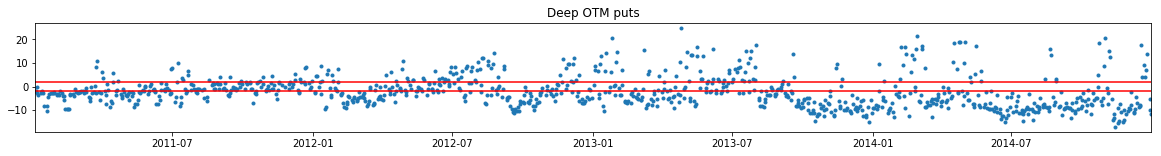

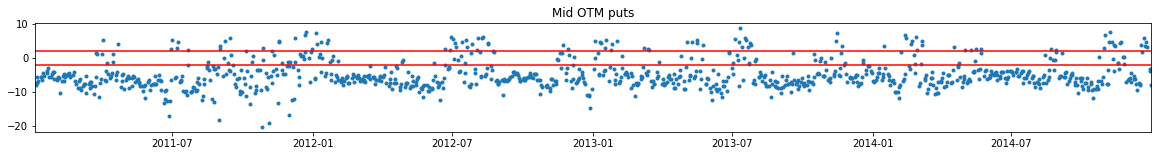

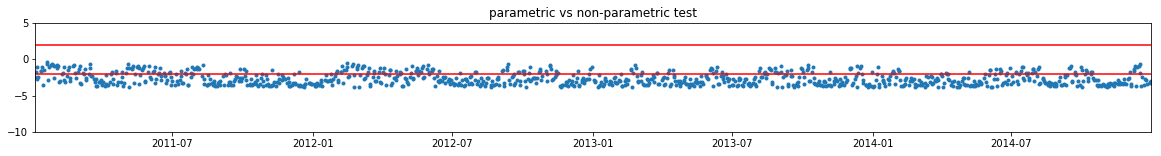

In [123]:
test_stats = run_tests(short_pre2015, V1_arr, V2_arr, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                     eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, sp500_m)

In [693]:
def get_params(option_dat, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    g = option_dat.groupby([date_col])
    num_dates = option_dat[[date_col]].drop_duplicates().shape[0]
    V1_arr = np.zeros(num_dates)
    V2_arr = np.zeros(num_dates)
    mse_arr = np.zeros(num_dates)
    ind = 0
    for date, options in g:
        g2 = options.groupby([exp_date_col])
        Nt = options.shape[0]
        X = np.log(options[indx_col].tolist()[0])
        
        if (ind == 0):
            V1 = vbar1
            V2 = vbar2
        else:
            V1 = V1_arr[ind-1]
            V2 = V2_arr[ind-1]
            
        V_est = sp500_m[sp500_m[date_col] == date]['V_est'].values[0]
        sum_sq = 0
        f = lambda V : MSE(g2, X, V[0], V[1], r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                          eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est)['avg_err']
        res = minimize(f, [V1, V2], method='L-BFGS-B', bounds= [(1e-4, 1), (1e-4, 1)], tol=1e-4)

        mse_arr[ind] = res.fun
        V1_arr[ind] = res.x[0]
        V2_arr[ind] = res.x[1]
        print('Iteration ', ind, ' of ', num_dates, ', Nt = ', Nt)
        ind += 1
        
    return {'MSE' : mse_arr, 'V1_arr': V1_arr, 'V2_arr': V2_arr}

In [694]:
r = 0.005
div_rate = 0.03
kappa1 = 2
vbar1 = 0.0173
sigma1 = 0.2678
rho1 = -1

kappa2 = 11.5
vbar2 = 0.001
sigma2 = 0.3708
rho2 = -0.72

eta0 = 0.0033
eta1 = 20.27
eta2 = 5.074
mu_x = -0.1241
sigma_x = 0.1141
mu_y = 0.0850
rho_j = -0.3260

estimation_dates = long_dated[[date_col]].drop_duplicates()
estimation_dates = estimation_dates[estimation_dates[date_col].apply(is_wed)].reset_index()

est_dat2 = pd.merge(long_dated, estimation_dates, on=date_col, how="inner")
est_dat_after = est_dat2[est_dat2[date_col] > '2015-01-01'].reset_index()
err_long_dated2 = get_params(est_dat_after, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_long_dated2['MSE'][~np.isnan(err_long_dated2['MSE'])]
print('The RMSE is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  0  of  54 , Nt =  818
Iteration  1  of  54 , Nt =  814
Iteration  2  of  54 , Nt =  792
Iteration  3  of  54 , Nt =  816
Iteration  4  of  54 , Nt =  762


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  5  of  54 , Nt =  639
Iteration  6  of  54 , Nt =  755
Iteration  7  of  54 , Nt =  753
Iteration  8  of  54 , Nt =  730


KeyboardInterrupt: 

In [691]:
est_dat_after[[date_col]].drop_duplicates()

,date
0,2015-01-07
818,2015-01-14
1632,2015-01-21
2424,2015-01-28
3240,2015-02-04
4002,2015-02-11
4641,2015-02-18
5396,2015-02-25
6149,2015-03-04
6879,2015-03-11


In [487]:
from collections import OrderedDict
def f(z, a, b, c, d, e):
        return z + a + b + c + d + e
    
def big_f(z, a, b, c, d, e):
    arg_dict = OrderedDict([('a', a), ('b', b), ('d', d), ('e', e)])
    for arg in arg_dict:
        temp = arg_dict[arg]
        arg_dict[arg] = a
        print(f(z, c=c, **arg_dict))
        arg_dict[arg] = temp
    
big_f(6, 1, 2, 3, 4, 5)

21
20
18
17


In [692]:
valid_dates

,date
0,2011-01-03
1,2011-01-04
2,2011-01-05
5,2011-01-10
6,2011-01-11
7,2011-01-12
10,2011-01-18
11,2011-01-19
13,2011-01-21
14,2011-01-24


(25001, 13)